# Torch Terrainer example

Example code to generate terrains and simulate erosion in PyTorch and use GPU acceleration if available.

Adapted to Pytorch from https://github.com/dandrino/terrain-erosion-3-ways/blob/master/simulation.py and included additional setting dataclass to ease invoking erosion iterations.

See https://github.com/dandrino/terrain-erosion-3-ways/tree/master for more info.

Sample Performance comparison generating erosion on a 1009x1009 terrain in 1412 iterations:
* Original Numpy code on CPU (AMD Ryzen 9 7900): 440.026s (3.30it/s)
* Pytorch code on CPU (AMD Ryzen 9 7900): 64.342s (22.00it/s)
* Pytorch code on GPU (AMD Ryzen 9 7900 + GeForce RTX 4080): 3.279s (440.21it/s)


MIT License

Original Copyright (c) 2018 Daniel Andrino

Copyright (c) 2024 Cristiano Costantini - Modifications and enhancements


In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
from torch_terrainer import *
from tqdm.notebook import tqdm

In [2]:
settings = SimulationSettings.from_dict(
    {
        "grid": {"size": 1009, "full_width": 200},
        "water": {"rain_unit_rate": 0.0008, "evaporation_rate": 0.0005},
        "slope": {
            "min_height_delta": 0.05,
            "repose_slope": 0.03,
            "gravity": 30.0,
            "gradient_sigma": 0.5,
        },
        "sediment": {
            "sediment_capacity_constant": 50.0,
            "dissolving_rate": 0.25,
            "deposition_rate": 0.001,
        },
    }
)

In [3]:
device = "cuda"

terrain = fbm((settings.grid.size, settings.grid.size), -2.0, seed=42.0, device=device)
sediment = torch.zeros_like(terrain, device=device)
water = torch.zeros_like(terrain, device=device)
velocity = torch.zeros_like(terrain, device=device)

In [4]:
iterations = int(1.4 * settings.grid.size)

start_time = time.time()
for i in tqdm(range(0, iterations)):
    terrain, sediment, water, velocity = iterate_terrain_erosion(
        settings, terrain, sediment, water, velocity
    )
end_time = time.time()

print(f"Processing completed in: {(end_time - start_time):.3f} seconds")

  0%|          | 0/1412 [00:00<?, ?it/s]

Processing completed in: 3.279 seconds


In [5]:
def save_terrain_as_raw(terrain, filename):
    # Normalize the terrain to the range [0, 65535] for 16-bit
    min_val = torch.min(terrain)
    max_val = torch.max(terrain)
    normalized_terrain = ((terrain - min_val) / (max_val - min_val) * 65535).to(
        torch.uint16
    )

    # Convert the tensor to a NumPy array and save to a raw file
    normalized_terrain.cpu().numpy().tofile(filename)


# save_terrain_as_raw(terrain, "torch_terrainer_heightmap.r16")

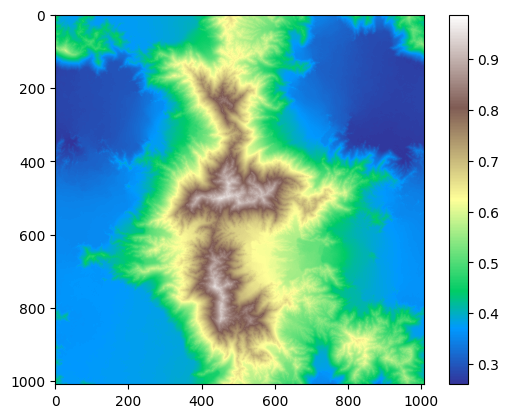

In [6]:
plt.imshow(terrain.cpu().numpy(), cmap="terrain")
plt.colorbar()
plt.show()